In [1]:
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import math
import copy

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

from cosmoprimo import *

from densitysplit import catalog_data, density_split
from densitysplit.split_model import *
from densitysplit.corr_func_utils import *
from densitysplit.edgeworth_development import *

# To activate logging
setup_logging()

## Cosmology

In [2]:
z = 1.175

# Abacus summit base cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()

k=np.logspace(-5, 3, 100000)

## General parameters

In [3]:
bias = 1.8
nbar = 0.01
nmesh = 512
boxsize = 1000
boxcenter = 500
cellsize = 10
resampler = 'tsc'

## Split model

In [4]:
kN = np.pi*nmesh/boxsize
kN

1.6084954386379742

In [5]:
def damping_function(k, k_lambda=0.8*kN, sigma_lambda=0.05*kN):
    if k < k_lambda:
        return 1
    else:
        return np.exp(-(k-k_lambda)**2/(2*sigma_lambda**2))

In [6]:
pklin = cosmo_abacus.get_fourier().pk_interpolator(extrap_kmin=1e-5, extrap_kmax=1e3).to_1d(z)
pklin_array = pklin(k)
pkdamped_func = lambda k: pklin(k) * np.array([damping_function(kk) for kk in k])
pkdamped = PowerSpectrumInterpolator1D.from_callable(k, pkdamped_func)
model = SplitCCFModel(k, redshift=z, cosmology=cosmo_abacus, pk=pkdamped, bias=bias, nsplits=1, shot_noise=0, nbar=nbar)

/feynman/work/dphp/adematti/cosmodesiconda/20220713-1.0.0/code/cosmoprimo/1.0.0/lib/python3.9/site-packages/cosmoprimo/interpolator.py:517: ComplexWarning: Casting complex values to real discards the imaginary part
  k = np.asarray(k, dtype=dtype)


In [8]:
# Get theoretical quantiles
import scipy.stats

th_bins = scipy.stats.norm.ppf(q=[0, 1./3, 2./3, 1], loc=0, scale=model.sigma_RR)
th_bins

array([       -inf, -0.21870731,  0.21870731,         inf])

## Generate mock

In [7]:
from mockfactory import RandomBoxCatalog, EulerianLinearMock

offset = boxcenter - boxsize/2.

test_mock = EulerianLinearMock(pkdamped, nmesh=nmesh, boxsize=boxsize, boxcenter=boxcenter, seed=0, unitary_amplitude=True, dtype='c16')
test_mock.set_real_delta_field(bias=bias)
test_data = RandomBoxCatalog(nbar=nbar, boxsize=boxsize, boxcenter=boxcenter, seed=0)
test_data['Weight'] = test_mock.readout(test_data['Position'], field='delta', resampler='tsc', compensate=True) + 1.
test_positions = copy.deepcopy((test_data['Position'] - offset) % boxsize + offset)
test_weights = copy.deepcopy(test_data['Weight'])
test_mock_catalog = catalog_data.Data(test_positions.T, z, boxsize, boxcenter, name='test', weights=test_weights)

mock_density = density_split.DensitySplit(test_mock_catalog)
mock_density.compute_density(cellsize=cellsize, resampler=resampler, use_rsd=False, use_weights=True)

[000245.81]  12-02 16:25  EulerianLinearMock           INFO     White noise generated.


/feynman/work/dphp/adematti/cosmodesiconda/20220713-1.0.0/code/cosmoprimo/1.0.0/lib/python3.9/site-packages/cosmoprimo/interpolator.py:517: ComplexWarning: Casting complex values to real discards the imaginary part
  k = np.asarray(k, dtype=dtype)


[000432.52]  12-02 16:29  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 1000000.
[000432.85]  12-02 16:29  CatalogMesh                  INFO     Painted 1000000 out of 1000000 objects to mesh.


In [8]:
## Generate random particles and readout density at each particle
rng = np.random.RandomState(seed=0)
positions = [o + rng.uniform(0., 1., mock_density.data.size)*b for o, b in zip((mock_density.offset,)*3, (mock_density.boxsize,)*3)]
shifted_positions = np.array(positions) - mock_density.offset
densities = mock_density.density_mesh.readout(shifted_positions.T, resampler=resampler)

## Compute theoretical density distribution with shot noise

In [9]:
p = 4
#shotnoise_cumulants = [model.smoothed_shot_noise_cumulant(i+1)/nbar**(i+1) * np.mean(mock_density.data.weights**(i+1)) for i in range(p)]
shotnoise_cumulants = [model.smoothed_density_cumulant(i+1) for i in range(p)]
shotnoise_cumulants[0] -= 1
print(shotnoise_cumulants)

gaussian_cumulants = [0 for i in range(p)]
gaussian_cumulants[1] = model.sigma_RR[0]**2
print(gaussian_cumulants)

cumulants = np.array(shotnoise_cumulants) # + np.array(gaussian_cumulants)
print(cumulants)

trunc_cumulants = np.array(shotnoise_cumulants[0:2]) #+ np.array(gaussian_cumulants[0:2])

0.9999999999999893
[1.61887095]
[3.06226957]
[6.99398009]
0.9999999999999893
[1.61887095]
[3.06226957]
[6.99398009]
0.9999999999999893
[1.61887095]
[3.06226957]
[6.99398009]
0.9999999999999893
[1.61887095]
[3.06226957]
[6.99398009]
[-1.0658141036401503e-14, 0.6188709499355121, 0.20565671890849224, 0.309123753279795]
[0, 0.25782308018865785, 0, 0]
[-1.06581410e-14  6.18870950e-01  2.05656719e-01  3.09123753e-01]


In [10]:
gauss_shotnoise = ExpandedNormal(cum=trunc_cumulants.tolist())
edgew = ExpandedNormal(cum=cumulants.tolist())
gauss = ExpandedNormal(cum=gaussian_cumulants)
#shotnoise = ExpandedNormal(cum=shotnoise_cumulants)
print(shotnoise_cumulants)
#trunc_shotnoise = ExpandedNormal(cum=shotnoise_cumulants[0:2])
x = np.linspace(-4, 4, 100)

[-1.0658141036401503e-14, 0.6188709499355121, 0.20565671890849224, 0.309123753279795]


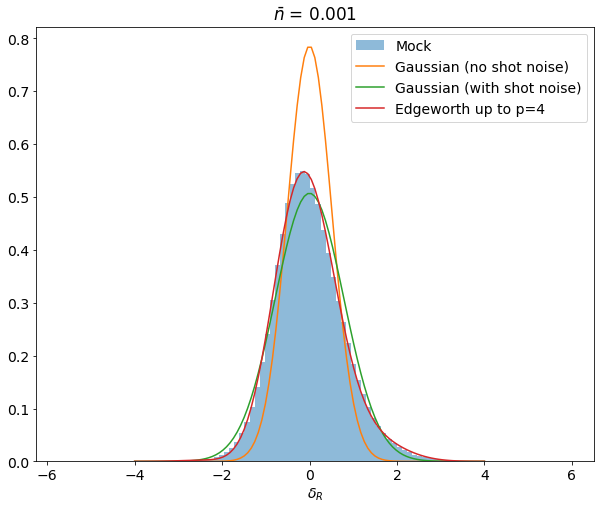

In [15]:
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

plt.hist(np.ravel(densities), bins=100, density=True, alpha=0.5, label = r'Mock')
plt.plot(x, gauss.pdf(x), label='Gaussian (no shot noise)')
#plt.plot(x, shotnoise.pdf(x), label='Shot noise')
#plt.plot(x, trunc_shotnoise.pdf(x), label='Gaussian shot noise')
plt.plot(x, gauss_shotnoise.pdf(x), label='Gaussian (with shot noise)')
plt.plot(x, edgew.pdf(x), label='Edgeworth up to p={}'.format(p))
plt.xlabel(r'$\delta_R$')
plt.legend()
plt.title(r'$\bar{{n}}$ = {:.3f}'.format(nbar))
plt.show()

In [12]:
fourier_kernel = model.smoothing_kernel_3D()
norm_fourier_kernel = fourier_kernel / model.boxsize**3
real_space_kernel = norm_fourier_kernel.c2r()
real_space_kernel.value = np.real(real_space_kernel.value)
xi_R_field = model.smoothed_pk_3D.c2r()
xi_R_field.value = np.real(xi_R_field.value)

In [13]:
w1 = integrate_pmesh_field(real_space_kernel)
res1 = w1
print(res1)

0.9999999999999893


In [14]:
w2 = integrate_pmesh_field(real_space_kernel**2)
## second order moment of delta*p/nbar
m2 = model.sigma**2 / model.nbar * w2 + model.sigma_RR**2
## second order moment of (1 + delta)*p/nbar
res2 = m2 + res1**2 + w2 / model.nbar
print(res2)

[1.61887095]
